In [4]:
# =============================================================================
# MOUNT DRIVE AND LOAD DATASET
# =============================================================================

from google.colab import drive
import pandas as pd

# mount google drive and load CSV
drive.mount('/content/gdrive')
file_path = 'gdrive/MyDrive/Colab Notebooks/Cleaned_Resume_ModelReady.csv'
df = pd.read_csv(file_path)

# display the data to check columns and shape
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
df.head()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Columns: ['job_position_name', 'skills_combined', 'model_text']
Shape: (9544, 3)


,job_position_name,skills_combined,model_text
0,Senior Software Engineer,"['big data', 'hadoop', 'hive', 'python', 'mapr...",big data analytics working database warehouse ...
1,Machine Learning (ML) Engineer,"['data analysis', 'data analytics', 'business ...",fresher looking join data analyst junior data ...
2,"Executive/ Senior Executive- Trade Marketing, ...","['software development', 'machine learning', '...",software development machine learning deep lea...
3,Business Development Executive,"['accounts payables', 'accounts receivables', ...",obtain position fast paced business office env...
4,Senior iOS Engineer,"['analytical reasoning', 'compliance testing k...",professional accountant outstanding work ethic...


In [ ]:
# =============================================================================
# COUNT UNIQUE JOB POSITIONS
# =============================================================================

import pandas as pd

# only output if job_position_name exists
if 'job_position_name' in df.columns:
    job_counts = df['job_position_name'].value_counts().reset_index()
    job_counts.columns = ['Job Position', 'Count']

    print("\n===== Job Position Counts =====")
    print(job_counts)

else:
    print("\nColumn 'job_position_name' not found in dataset.")


===== Job Position Counts =====
                                         Job Position  Count
0                         Project Coordinator (Civil)    342
1                                       Site Engineer    342
2                                      Civil Engineer    342
3                                          HR Officer    342
4                        Database Administrator (DBA)    341
5                                         AI Engineer    341
6                                 Mechanical Designer    341
7                                 Mechanical Engineer    341
8   System Administrator (Operation & Maintenance ...    341
9                            Senior Software Engineer    341
10                     Business Development Executive    341
11  Executive/ Senior Executive- Trade Marketing, ...    341
12                                  Marketing Officer    341
13  Head of Internal Control & Compliance (ICC) - ...    341
14             Asst. Manager/ Manger (Administrative

In [5]:
# =============================================================================
# PREPROCESS AND SPLIT DATA
# =============================================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# define label
labels = df['job_position_name']

# further clean skills text for model processing
def clean_text(text):
    text = str(text).lower()                  # convert to string and lowercase
    text = text.replace('\n', ' ')            # replace newlines with spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)  # remove any non-alphanumeric characters except spaces
    text = re.sub(r'\s+', ' ', text)          # collapse multiple spaces into one

    return text.strip()

# apply cleaning to skills_combined column
df['skills_combined'] = df['skills_combined'].apply(clean_text)

# use only skills column as input features
text_features = df['skills_combined']

# encode labels into numeric form
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# convert text to TF-IDF numeric features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(text_features)
y = labels_encoded

# split dataset into 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=0, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp
)

# print split sizes
print("Training samples:", len(y_train))
print("Validation samples:", len(y_val))
print("Test samples:", len(y_test))

Training samples: 5726
Validation samples: 1909
Test samples: 1909


In [7]:
# =============================================================================
# TRAIN RANDOM FOREST MODEL ON TRAINING DATA
# =============================================================================

from sklearn.ensemble import RandomForestClassifier

# create basic random forest classifier
rf_model = RandomForestClassifier(
    n_estimators=200,          # number of trees
    random_state=0,
    n_jobs=-1                  # use all CPU cores
)

# fit model on training data
rf_model.fit(X_train, y_train)

# check training and validation accuracy
print("Training Accuracy:", rf_model.score(X_train, y_train))
print("Validation Accuracy:", rf_model.score(X_val, y_val))

Training Accuracy: 0.8803702410059379
Validation Accuracy: 0.821896280775275


In [8]:
# =============================================================================
# RANDOM FOREST WITH HYPERPARAMETER TUNING (RANDOMIZED SEARCH)
# =============================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint
import numpy as np
from scipy.sparse import vstack

# combine training + validation sets for final training after tuning
X_combined = vstack([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])


# ========== DEFINE RANDOM FOREST AND SEARCH SPACE ==========
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

# reasonable space to search
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 40),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}


# ========== RANDOMIZED SEARCH (FASTER THAN GRID SEARCH) ==========
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,            # stays fast while still exploring enough iterations
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# fit search on training set only
rf_search.fit(X_train, y_train)

# best hyperparameters from search
best_params = rf_search.best_params_
print("\nBest Hyperparameters Found:")
print(best_params)


Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Hyperparameters Found:
{'bootstrap': True, 'class_weight': None, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 188}


In [9]:
# =============================================================================
# TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS
# =============================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# define best forest classifier
final_rf = RandomForestClassifier(
    random_state=0,
    n_jobs=-1,
    **best_params
)

# fit on combined training + validation set
final_rf.fit(X_combined, y_combined)

# predict on training + validation set
y_trainval_pred = final_rf.predict(X_combined)
trainval_acc = accuracy_score(y_combined, y_trainval_pred)

# predict on validation set
y_val_pred = final_rf.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

# predict on test set
y_test_pred = final_rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

In [10]:
# =============================================================================
# PRINT FINAL ACCURACY METRICS AND CLASSIFICATION REPORT
# =============================================================================

from sklearn.metrics import classification_report

print("\nFinal Random Forest Accuracy Metrics:")
print("Training+Validation Accuracy:", round(trainval_acc, 3))
print("Validation Accuracy:", round(val_acc, 3))
print("Test Accuracy:", round(test_acc, 3))

print("\nClassification Report (Random Forest):")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))



Final Random Forest Accuracy Metrics:
Training+Validation Accuracy: 0.865
Validation Accuracy: 0.864
Test Accuracy: 0.822

Classification Report (Random Forest):
                                                                                         precision    recall  f1-score   support

                                                                            AI Engineer       1.00      1.00      1.00        68
                                                 Asst. Manager/ Manger (Administrative)       0.99      1.00      0.99        68
                                                         Business Development Executive       1.00      1.00      1.00        69
                                                                         Civil Engineer       1.00      1.00      1.00        68
                                                                          Data Engineer       1.00      1.00      1.00        68
                                                              

Top 100 Most Important Features for Predictions:


,feature,importance
1552,nsolidworks,0.013720
1532,noperation,0.013161
1517,nmechanical,0.012641
25,2d,0.012506
1556,ntensorflow,0.012496
...,...,...
2105,skills,0.004966
1546,nredis,0.004961
1524,nnative,0.004886
2396,understanding,0.004790


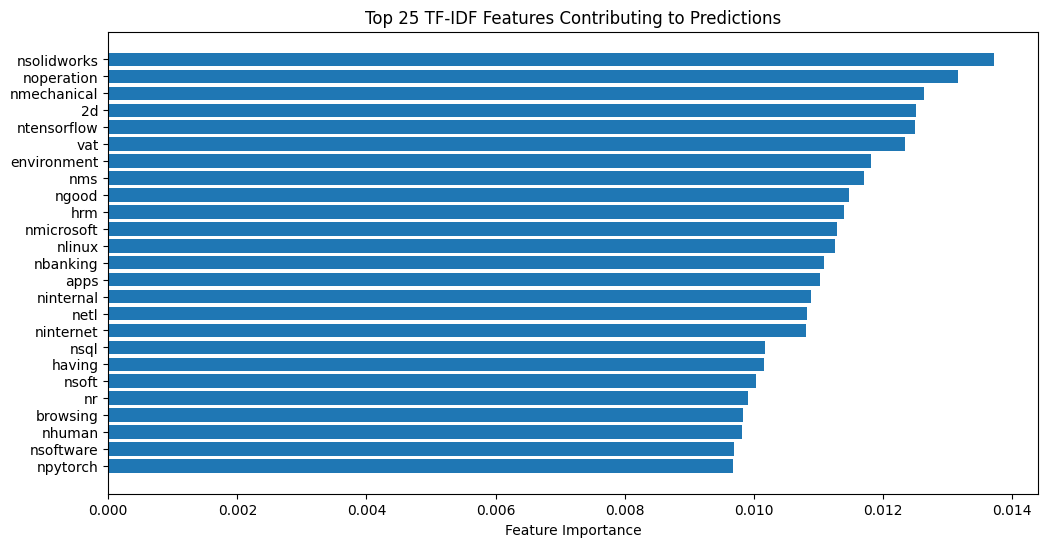

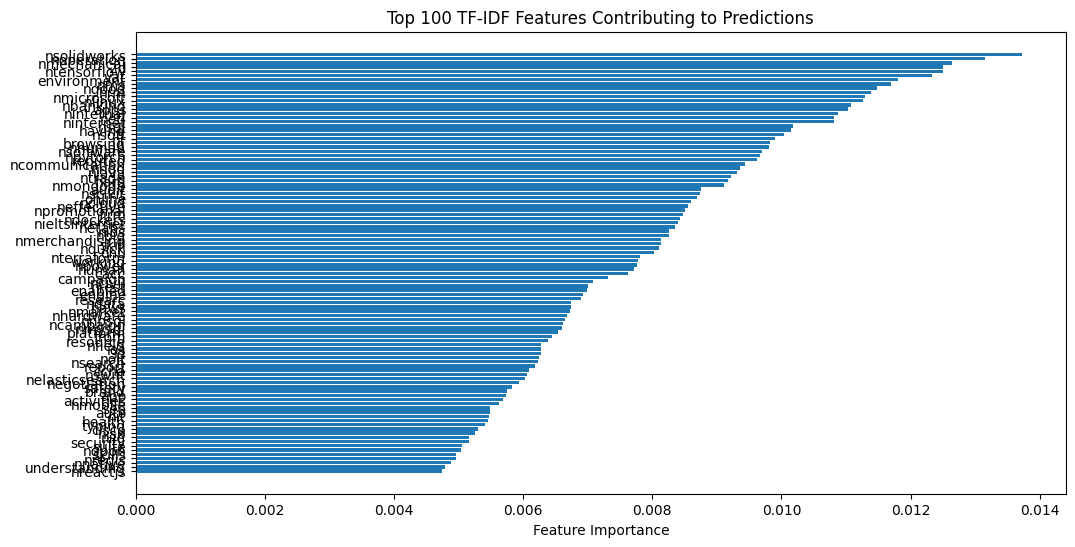

In [11]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt

feature_importances = final_rf.feature_importances_
feature_names = vectorizer.get_feature_names_out()

feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# sort by importance descending
feat_df = feat_df.sort_values(by='importance', ascending=False)

# show top 100
print("Top 100 Most Important Features for Predictions:")
display(feat_df.head(100))

# plot top 25
plt.figure(figsize=(12,6))
plt.barh(feat_df['feature'].head(25)[::-1], feat_df['importance'].head(25)[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 25 TF-IDF Features Contributing to Predictions")
plt.show()

# plot top 100
plt.figure(figsize=(12,6))
plt.barh(feat_df['feature'].head(100)[::-1], feat_df['importance'].head(100)[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 100 TF-IDF Features Contributing to Predictions")
plt.show()


In [12]:
# =============================================================================
# INTERACTIVE RESUME PREDICTION (WITH CLEANING)
# =============================================================================

import ipywidgets as widgets
from IPython.display import display
import re

# text input widget
skills_input = widgets.Textarea(
    value='',
    placeholder='Paste your skills and resume text here...',
    description='Resume:',
    layout=widgets.Layout(width='70%', height='100px')
)

# button to predict
predict_button = widgets.Button(
    description='Predict Job Position',
    button_style='success'
)

# output widget
output = widgets.Output()

# cleaning function for input text
def clean_input(text):
    text = str(text).replace(',', '\n')
    skills_list = text.split('\n')
    cleaned_skills = []
    for skill in skills_list:
        skill = skill.strip().lower()
        skill = re.sub(r'\bn([a-z]+)\b', r'\1', skill)
        skill = re.sub(r'[^a-z0-9\s]', ' ', skill)
        skill = re.sub(r'\s+', ' ', skill)
        if skill:
            cleaned_skills.append(skill)
    return ' '.join(cleaned_skills)

# prediction function
def predict_resume(job):
    with output:
        output.clear_output()
        text = skills_input.value
        if text.strip() == "":
            print("Please enter your resume text!")
            return
        text_cleaned = clean_input(text)
        text_vector = vectorizer.transform([text_cleaned])
        pred_num = final_rf.predict(text_vector)[0]
        pred_label = label_encoder.inverse_transform([pred_num])[0]
        print("Predicted Job Position:", pred_label)

# link button to function
predict_button.on_click(predict_resume)

# display interactive widgets
display(skills_input, predict_button, output)


Textarea(value='', description='Resume:', layout=Layout(height='100px', width='70%'), placeholder='Paste your …

Button(button_style='success', description='Predict Job Position', style=ButtonStyle())

Output()

In [13]:
import joblib

# Save model, vectorizer, and encoder
joblib.dump(final_rf, 'model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']